# 6.5  卷积网络进行情感分类

**Daitu：2505131775@qq.com**

In [23]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [24]:
## 导入本章所需要的模块
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
import seaborn as sns
from wordcloud import WordCloud
import time
import copy


import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchtext import data
from torchtext.vocab import Vectors, GloVe

## 文本数据预处理和探索性分析

### 文本预处理

使用数据出自：https://www.kaggle.com/iarunava/imdb-movie-reviews-dataset

In [25]:
## 读取训练数据和测试数据
def load_text_data(path):
    ## 获取文件夹的最后一个字段
    text_data = []
    label = []
    for dset in ["pos","neg"]:
        path_dset = os.path.join(path,dset)
        path_list = os.listdir(path_dset)
        ## 读取文件夹下的pos或neg文件
        for fname in path_list:
            if fname.endswith(".txt"):
                filename = os.path.join(path_dset,fname)
                with open(filename) as f:
                    text_data.append(f.read())
            if dset == "pos":
                label.append(1)
            else:
                label.append(0)
    ##  输出读取的文本和对应的标签
    return np.array(text_data),np.array(label)
    

In [26]:
## 读取训练集和测试集
train_path = "data/chap6/imdb/train"
train_text,train_label = load_text_data(train_path)
test_path = "data/chap6/imdb/test"
test_text,test_label = load_text_data(test_path)
print(len(train_text),len(train_label))
print(len(test_text),len(test_label))

25000 25000
25000 25000


In [27]:
train_text[0:2]

array([ 'Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!',
       'Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan to help those on the street that were once considered human who did e

In [28]:
string.punctuation[6]
string.punctuation.replace("'","")

'!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~'

In [29]:
## 对文本数据进行预处理
def text_preprocess(text_data):
    text_pre = []
    for text1 in text_data:
        ## 去除指定的字符 <br /><br />
        text1 = re.sub("<br /><br />", " ", text1)
        ## 转化为小写,去除数字,去除标点符号,去除空格
        text1 = text1.lower()
        text1 = re.sub("\d+", "", text1)
        text1 = text1.translate(
            str.maketrans("","", string.punctuation.replace("'","")))
        text1 = text1.strip() 
        text_pre.append(text1)
    return np.array(text_pre)

In [30]:
train_text_pre = text_preprocess(train_text)
test_text_pre = text_preprocess(test_text)
print(train_text[10000])
print("="*10)
print(train_text_pre[10000])

I really liked Tom Barman's AWTWB. You just have to let it come over you and enjoy it while it lasts, and don't expect anything. It's like sitting on a café-terrace with a beer, in the summer sun, and watching the people go by. It definitely won't keep you pondering afterwards, that's true, but that's not a prerequisite for a good film. It's just the experience during the movie that's great.<br /><br />I felt there were a few strands that could have been worked out a little more, but being a Lynch fan I don't care that much anymore :)<br /><br />And I *loved* the style, or flair of this movie. It's slick, but fresh, and the soundtrack is a beauty. Any music-lover will get his kicks out of AWTWB, I can assure you.<br /><br />I'll give it 8 out 10.<br /><br />(music-wise 10 out of 10)
i really liked tom barman's awtwb you just have to let it come over you and enjoy it while it lasts and don't expect anything it's like sitting on a caféterrace with a beer in the summer sun and watching th

In [31]:
print(train_text[100])
print("="*10)
print(train_text_pre[100])

I was prepared for a turgid talky soap opera cum travelogue, but was pleased to find a fast-paced script, an underlying moral, excellent portrayals from all the actors, especially Peter Finch, amazing special effects, suspense, and beautiful cinematography--there's even a shot of the majestic stone Buddhas recently destroyed by the Taliban. Not to mention Elizabeth Taylor at her most gloriously beautiful and sympathetic, before she gave in to the gaspy hysterics that marred her later work. All the supporting players round it out, and I do wonder who trained all those elephants.<br /><br />Speaking of the stone-Buddha sequence, you really can discern that it's Vivien Leigh in the long shots. Her shape and the way she moves is distinct from Taylor's. The only thing marring that sequence are the poorly done process shots, where the background moves by much too fast for horses at a walk.<br /><br />If you want a thought-provoking film that is beautiful to watch and never boring, spend a fe

In [32]:
print(train_text_pre[10000])

i really liked tom barman's awtwb you just have to let it come over you and enjoy it while it lasts and don't expect anything it's like sitting on a caféterrace with a beer in the summer sun and watching the people go by it definitely won't keep you pondering afterwards that's true but that's not a prerequisite for a good film it's just the experience during the movie that's great i felt there were a few strands that could have been worked out a little more but being a lynch fan i don't care that much anymore  and i loved the style or flair of this movie it's slick but fresh and the soundtrack is a beauty any musiclover will get his kicks out of awtwb i can assure you i'll give it  out  musicwise  out of


In [33]:
## 查看停用词
print(stopwords.words("english"))
print(len(stopwords.words("english")))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [34]:
## 文本符号化处理,去除停用词，词干化处理
def stop_stem_word(datalist,stop_words,stemer):
    datalist_pre = []
    for text in datalist:
        text_words = word_tokenize(text) 
        ## 去除停用词
        text_words = [word for word in text_words
                      if not word in stop_words]
        ## 删除带“‘”的词语
        text_words = [word for word in text_words
                      if len(re.findall("'",word)) == 0]
        ## 词干化处理
#         text_words = [stemmer.stem(word) for word in text_words]
        datalist_pre.append(text_words)
    return np.array(datalist_pre)


In [35]:
## 文本符号化处理,去除停用词，词干化处理
stop_words = stopwords.words("english")
stop_words = set(stop_words)
stemmer= PorterStemmer()
train_text_pre2 = stop_stem_word(train_text_pre,stop_words,stemmer)
test_text_pre2 = stop_stem_word(test_text_pre,stop_words,stemmer)
print(train_text_pre[10000])
print("="*10)
print(train_text_pre2[10000])

i really liked tom barman's awtwb you just have to let it come over you and enjoy it while it lasts and don't expect anything it's like sitting on a caféterrace with a beer in the summer sun and watching the people go by it definitely won't keep you pondering afterwards that's true but that's not a prerequisite for a good film it's just the experience during the movie that's great i felt there were a few strands that could have been worked out a little more but being a lynch fan i don't care that much anymore  and i loved the style or flair of this movie it's slick but fresh and the soundtrack is a beauty any musiclover will get his kicks out of awtwb i can assure you i'll give it  out  musicwise  out of
['really', 'liked', 'tom', 'barman', 'awtwb', 'let', 'come', 'enjoy', 'lasts', 'expect', 'anything', 'like', 'sitting', 'caféterrace', 'beer', 'summer', 'sun', 'watching', 'people', 'go', 'definitely', 'wo', 'keep', 'pondering', 'afterwards', 'true', 'prerequisite', 'good', 'film', 'ex

In [36]:
print(train_text_pre2[3])

['easily', 'underrated', 'film', 'inn', 'brooks', 'cannon', 'sure', 'flawed', 'give', 'realistic', 'view', 'homelessness', 'unlike', 'say', 'citizen', 'kane', 'gave', 'realistic', 'view', 'lounge', 'singers', 'titanic', 'gave', 'realistic', 'view', 'italians', 'idiots', 'many', 'jokes', 'fall', 'flat', 'still', 'film', 'lovable', 'way', 'many', 'comedies', 'pull', 'story', 'traditionally', 'reviled', 'members', 'society', 'truly', 'impressive', 'fisher', 'king', 'crap', 'either', 'complaint', 'brooks', 'cast', 'someone', 'else', 'lead', 'love', 'mel', 'director', 'writer', 'much', 'lead']


In [37]:
## 将处理好的文本保存到CSV文件中
texts = [" ".join(words) for words in train_text_pre2]
traindatasave = pd.DataFrame({"text":texts,
                              "label":train_label})
texts = [" ".join(words) for words in test_text_pre2]
testdatasave = pd.DataFrame({"text":texts,
                              "label":test_label})
traindatasave.to_csv("data/chap6/imdb_train.csv",index=False)
testdatasave.to_csv("data/chap6/imdb_test.csv",index=False)
print(traindatasave.head())
print(testdatasave.head())

   label                                               text
0      1  bromwell high cartoon comedy ran time programs...
1      1  homelessness houselessness george carlin state...
2      1  brilliant overacting lesley ann warren best dr...
3      1  easily underrated film inn brooks cannon sure ...
4      1  typical mel brooks film much less slapstick mo...
   label                                               text
0      1  went saw movie last night coaxed friends mine ...
1      1  actor turned director bill paxton follows prom...
2      1  recreational golfer knowledge sport history pl...
3      1  saw film sneak preview delightful cinematograp...
4      1  bill paxton taken true story us golf open made...


In [38]:
len(texts)

25000

In [39]:
texts[1]

'actor turned director bill paxton follows promising debut gothichorror frailty family friendly sports drama us open young american caddy rises humble background play bristish idol dubbed greatest game ever played fan golf scrappy underdog sports flicks dime dozen recently done grand effect miracle cinderella man film enthralling film starts creative opening credits imagine disneyfied version animated opening credits hbo carnivale rome lumbers along slowly first bythenumbers hour action moves us open things pick well paxton nice job shows knack effective directorial flourishes loved rainsoaked montage action day two open propel plot add unexpected psychological depth proceedings compelling character development british harry vardon haunted images aristocrats black suits top hats destroyed family cottage child make way golf course also good job visually depicting goes players heads pressure golf painfully boring sport brought vividly alive credit also given set designers costume departm

### 文本数据可视化

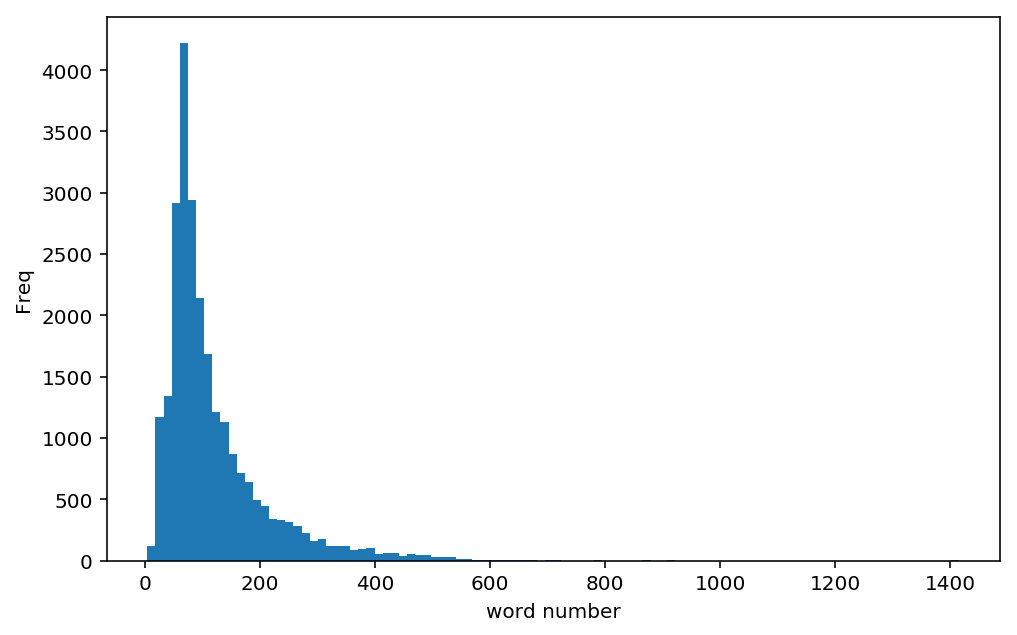

,train_label,train_text,train_word,train_word_num
0,1,Bromwell High is a cartoon comedy. It ran at t...,"[bromwell, high, cartoon, comedy, ran, time, p...",69
1,1,Homelessness (or Houselessness as George Carli...,"[homelessness, houselessness, george, carlin, ...",204
2,1,Brilliant over-acting by Lesley Ann Warren. Be...,"[brilliant, overacting, lesley, ann, warren, b...",84
3,1,This is easily the most underrated film inn th...,"[easily, underrated, film, inn, brooks, cannon...",61
4,1,This is not the typical Mel Brooks film. It wa...,"[typical, mel, brooks, film, much, less, slaps...",53


In [40]:
## 将预处理好的文本数据转化为数据表
traindata = pd.DataFrame({"train_text":train_text,
                          "train_word":train_text_pre2,
                          "train_label":train_label})
# testdata = pd.DataFrame({"test_text":test_text,
#                          "test_word":test_text_pre2})
traindata.head()
## 计算每个个影评使用词的数量
train_word_num = [len(text) for text in train_text_pre2]
traindata["train_word_num"] = train_word_num
##可视化影评词语长度的分布
plt.figure(figsize=(8,5))
_ = plt.hist(train_word_num,bins=100)
plt.xlabel("word number")
plt.ylabel("Freq")
plt.show()
traindata.head()

0
1


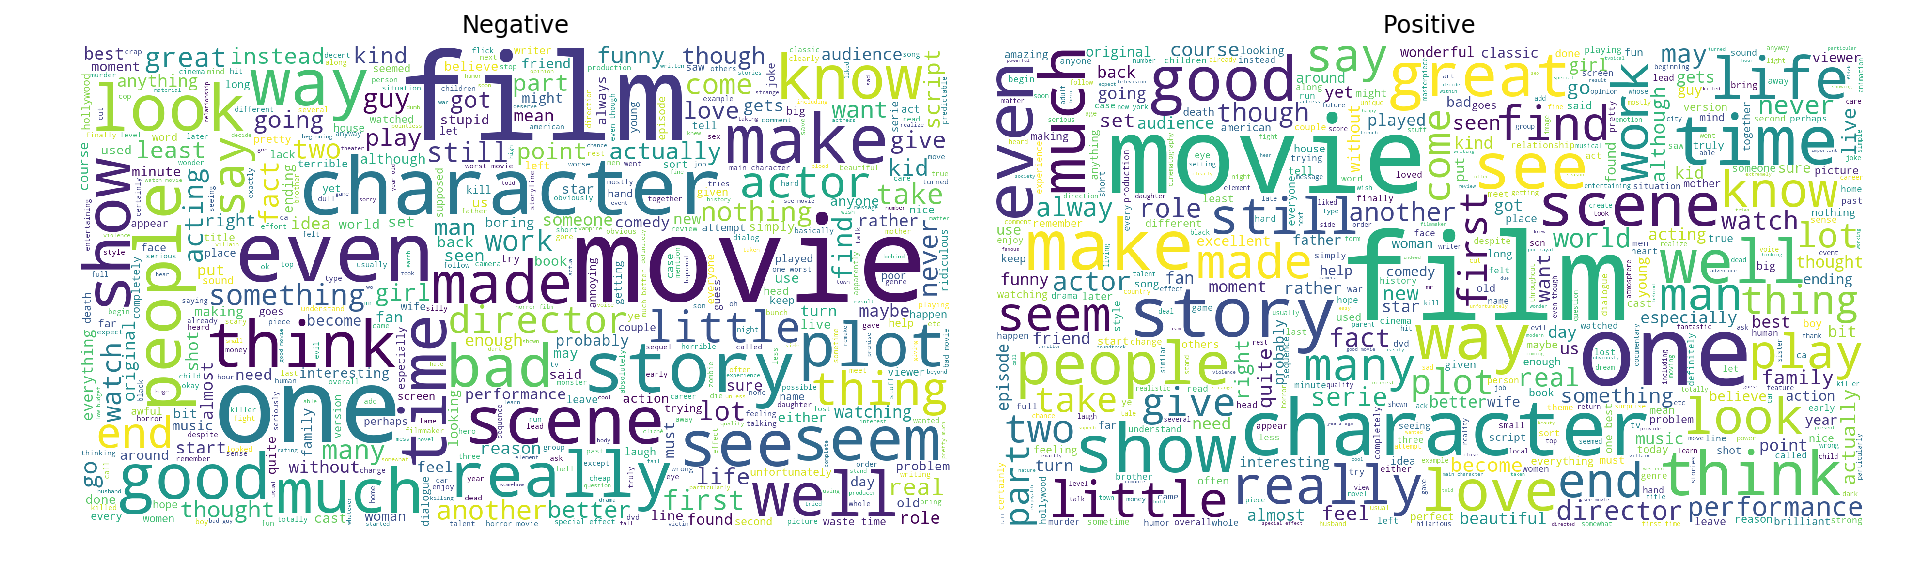

In [41]:
## 使用词云可视化两种情感的词频差异
plt.figure(figsize=(16,10))
for ii in np.unique(train_label):
    ## 准备每种情感的所有词语
    print(ii)
    text = np.array(traindata.train_word[traindata.train_label == ii])
    text = " ".join(np.concatenate(text))
    plt.subplot(1,2,ii+1)
    ## 生成词云
    wordcod = WordCloud(margin=5,width=1800, height=1000,
                        max_words=500, min_font_size=5, 
                        background_color='white',
                        max_font_size=250)
    wordcod.generate_from_text(text)
    plt.imshow(wordcod)
    plt.axis("off")
    if ii == 1:
        plt.title("Positive")
    else:
        plt.title("Negative")
    plt.subplots_adjust(wspace=0.05)
plt.show()

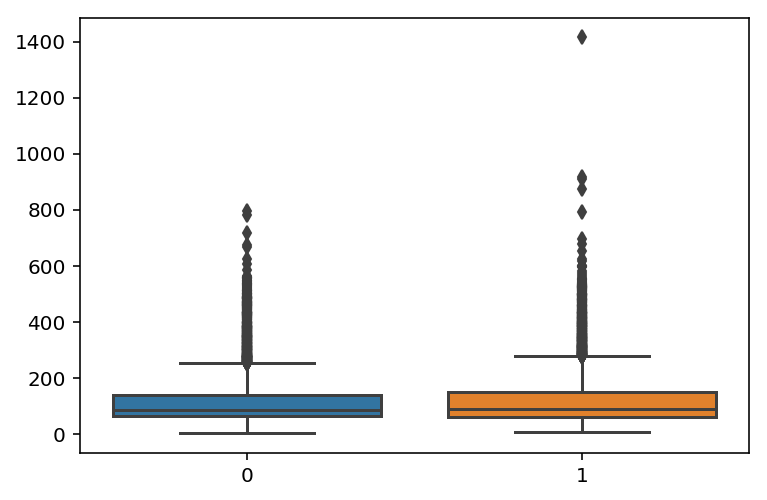

In [42]:
## 可视化正面和负面评论用词分布的差异
sns.boxplot(x=train_label, y=train_word_num,)

### CNN网络准备

#### 数据准备

Tokenizer：将句子分成单词列表。如果sequential = False，则不应用标记化

Field:存储有关预处理方式的信息的类

In [43]:
## 使用torchtext库进行数据准备
# 定义文件中对文本和标签所要做的操作
"""
sequential=True:表明输入的文本时字符，而不是数值字
tokenize="spacy":使用spacy切分词语
use_vocab=True: 创建一个词汇表
batch_first=True: batch悠闲的数据方式
fix_length=200 :每个句子固定长度为200
"""
## 定义文本切分方法，因为前面已经做过处理，所以直接使用空格切分即可
mytokenize = lambda x: x.split()
TEXT = data.Field(sequential=True, tokenize=mytokenize, 
                  include_lengths=True, use_vocab=True,
                  batch_first=True, fix_length=200)
LABEL = data.Field(sequential=False, use_vocab=False, 
                   pad_token=None, unk_token=None)
## 对所要读取的数据集的列进行处理
train_test_fields = [
    ("label", LABEL), # 对标签的操作
    ("text", TEXT) # 对文本的操作
]
## 读取数据
traindata,testdata = data.TabularDataset.splits(
    path="./data/chap6", format="csv", 
    train="imdb_train.csv", fields=train_test_fields, 
    test = "imdb_test.csv", skip_header=True
)

In [44]:
len(traindata),len(testdata)

(25000, 25000)

In [45]:
traindata.fields.items()

dict_items([('text', <torchtext.data.field.Field object at 0x1bab1c9f28>), ('label', <torchtext.data.field.Field object at 0x1bab1c9080>)])

In [46]:
## TabularDataset是一个包含Example对象的列表。
ex0 = traindata.examples[0]
print(ex0.label)
print(ex0.text)

1
['bromwell', 'high', 'cartoon', 'comedy', 'ran', 'time', 'programs', 'school', 'life', 'teachers', 'years', 'teaching', 'profession', 'lead', 'believe', 'bromwell', 'high', 'satire', 'much', 'closer', 'reality', 'teachers', 'scramble', 'survive', 'financially', 'insightful', 'students', 'see', 'right', 'pathetic', 'teachers', 'pomp', 'pettiness', 'whole', 'situation', 'remind', 'schools', 'knew', 'students', 'saw', 'episode', 'student', 'repeatedly', 'tried', 'burn', 'school', 'immediately', 'recalled', 'high', 'classic', 'line', 'inspector', 'sack', 'one', 'teachers', 'student', 'welcome', 'bromwell', 'high', 'expect', 'many', 'adults', 'age', 'think', 'bromwell', 'high', 'far', 'fetched', 'pity']


In [47]:
## 训练集切分为训练集和验证集
train_data, val_data = traindata.split(split_ratio=0.7)
len(train_data),len(val_data)

(17500, 7500)

In [48]:
## 加载预训练的词向量和构建词汇表
## Torchtext使得预训练的词向量的加载变得非常容易。
## 只需提及预训练单词向量的名称（例如glove.6B.50d，fasttext.en.300d等）

vec = Vectors("glove.6B.100d.txt", "./data")

# 将训练集和验证集转化为词项量

## 使用训练集构建单词表，导入预先训练的词嵌入
TEXT.build_vocab(train_data,max_size=20000,vectors = vec)
LABEL.build_vocab(train_data)
## 训练集中的前10个高频词
print(TEXT.vocab.freqs.most_common(n=10))
print("词典的词数:",len(TEXT.vocab.itos))
print("前10个单词:\n",TEXT.vocab.itos[0:10])
## 类别标签的数量和类别
print("类别标签情况:",LABEL.vocab.freqs)

[('movie', 30195), ('film', 27564), ('one', 18230), ('like', 13660), ('good', 10193), ('would', 9356), ('even', 8669), ('time', 8476), ('story', 8223), ('really', 8119)]
词典的词数: 20002
前10个单词:
 ['<unk>', '<pad>', 'movie', 'film', 'one', 'like', 'good', 'would', 'even', 'time']
类别标签情况: Counter({'1': 8762, '0': 8738})


In [49]:
## 查看某个词对应的词项量
TEXT.vocab.vectors[TEXT.vocab.stoi["movie"]]

tensor([ 0.3825,  0.1482,  0.6060, -0.5153,  0.4399,  0.0611, -0.6272, -0.0254,
         0.1643, -0.2210,  0.1442, -0.3721, -0.2168, -0.0890,  0.0979,  0.6561,
         0.6446,  0.4770,  0.8385,  1.6486,  0.8892, -0.1181, -0.0125, -0.5208,
         0.7785,  0.4872, -0.0150, -0.1413, -0.3475, -0.2959,  0.1028,  0.5719,
        -0.0456,  0.0264,  0.5382,  0.3226,  0.4079, -0.0436, -0.1460, -0.4835,
         0.3204,  0.5509, -0.7626,  0.4327,  0.6175, -0.3650, -0.6060, -0.7962,
         0.3929, -0.2367, -0.3472, -0.6120,  0.5475,  0.9481,  0.2094, -2.7771,
        -0.6022,  0.8495,  1.2549,  0.0179, -0.0419,  2.1147, -0.0266, -0.2810,
         0.6812, -0.1417,  0.9925,  0.4988, -0.6754,  0.6417,  0.4230, -0.2791,
         0.0634,  0.6891, -0.3618,  0.0537, -0.1681,  0.1942, -0.4707, -0.1480,
        -0.5899, -0.2797,  0.1679,  0.1057, -1.7601,  0.0088, -0.8333, -0.5836,
        -0.3708, -0.5659,  0.2070,  0.0713,  0.0556, -0.2976, -0.0727, -0.2560,
         0.4269,  0.0589,  0.0911,  0.47

In [50]:
## 定义一个迭代器，将类似长度的示例一起批处理
BATCH_SIZE = 32
train_iter = data.BucketIterator(train_data,batch_size = BATCH_SIZE)
val_iter = data.BucketIterator(val_data,batch_size = BATCH_SIZE)
test_iter = data.BucketIterator(testdata,batch_size = BATCH_SIZE)

In [51]:
##  获得一个batch的数据，对数据进行内容进行介绍
for step, batch in enumerate(train_iter):  
    if step > 0:
        break
## 针对一个batch 的数据，可以使用batch.label获得数据的类别标签
print("数据的类别标签:\n",batch.label)
## batch.text[0]是文本对应的标签向量
print("数据的尺寸:",batch.text[0].shape)
## batch.text[1] 对应每个batch使用的原始数据中的索引
print("数据样本数:",len(batch.text[1]))

数据的类别标签:
 tensor([1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 1, 0, 1])
数据的尺寸: torch.Size([32, 200])
数据样本数: 32


In [52]:
##  获得一个batch的数据，对数据进行内容进行介绍
for step, batch in enumerate(val_iter):  
    if step > 0:
        break
## 针对一个batch 的数据，可以使用batch.label获得数据的类别标签
print("数据的类别标签:\n",batch.label)
## batch.text[0]是文本对应的标签向量
print("数据的尺寸:",batch.text[0].shape)
## batch.text[1] 对应每个batch使用的原始数据中的索引
print("数据样本数:",len(batch.text[1]))

数据的类别标签:
 tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 1, 0, 0, 0, 1, 1, 0])
数据的尺寸: torch.Size([32, 200])
数据样本数: 32


 ### 构建网络

In [53]:
class CNN_Text(nn.Module):
    def __init__(self,vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        super().__init__()
        """
        vocab_size:词典大小;embedding_dim:词向量维度;
        n_filters:卷积核的个数,filter_sizes:卷积核的尺寸;
        output_dim:输出的维度;pad_idx:填充的索引
        """
        ## 对文本进行词项量
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        ## 卷积操作
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels = 1, out_channels = n_filters, 
                      kernel_size = (fs, embedding_dim)) for fs in filter_sizes
                                    ])
        ## 全连接层和Dropout层
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        #text = [batch size, sent len]
        embedded = self.embedding(text)    
        #embedded = [batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1)
        #embedded = [batch size, 1, sent len, emb dim]
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        #pooled_n = [batch size, n_filters]
        cat = self.dropout(torch.cat(pooled, dim = 1))
        #cat = [batch size, n_filters * len(filter_sizes)]   
        return self.fc(cat)
                

In [54]:
INPUT_DIM = len(TEXT.vocab) # 词典的数量
EMBEDDING_DIM = 100  # 词向量的维度
N_FILTERS = 100  ## 每个卷积核的个数
FILTER_SIZES = [3,4,5] ## 卷积和的高度
OUTPUT_DIM = 1  
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] # 填充词的索引
model = CNN_Text(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
model

CNN_Text(
  (embedding): Embedding(20002, 100, padding_idx=1)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(4, 100), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(5, 100), stride=(1, 1))
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
  (dropout): Dropout(p=0.5)
)

### 网络训练和预测

In [55]:
## 将导入的词项量作为embedding.weight的初始值
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)
## 将无法识别的词'<unk>', '<pad>'的向量初始化为0
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [56]:
## Adam优化,二分类交叉熵作为损失函数
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

In [57]:
## 定义一个对数据集训练一轮的函数
def train_epoch(model, iterator, optimizer, criterion):
    epoch_loss = 0;epoch_acc = 0
    train_corrects = 0;train_num = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        pre = model(batch.text[0]).squeeze(1)
        loss = criterion(pre, batch.label.type(torch.FloatTensor))
        pre_lab = torch.round(torch.sigmoid(pre))
        train_corrects += torch.sum(pre_lab.long() == batch.label)
        train_num += len(batch.label) ## 样本数量
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    ## 所有样本的平均损失和精度
    epoch_loss = epoch_loss / train_num 
    epoch_acc = train_corrects.double().item() / train_num
    return epoch_loss, epoch_acc

In [58]:
## 定义一个对数据集验证一轮的函数
def evaluate(model, iterator, criterion):
    epoch_loss = 0;epoch_acc = 0
    train_corrects = 0;train_num = 0
    model.eval()
    with torch.no_grad(): # 禁止梯度计算
        for batch in iterator:
            pre = model(batch.text[0]).squeeze(1)
            loss = criterion(pre, batch.label.type(torch.FloatTensor))
            pre_lab = torch.round(torch.sigmoid(pre))
            train_corrects += torch.sum(pre_lab.long() == batch.label)
            train_num += len(batch.label) ## 样本数量
            epoch_loss += loss.item()
        ## 所有样本的平均损失和精度
        epoch_loss = epoch_loss / train_num 
        epoch_acc = train_corrects.double().item() / train_num
    return epoch_loss, epoch_acc   

In [59]:
## 使用训练集训练模型，验证集测试模型
EPOCHS = 10
best_val_loss = float("inf")
best_acc  = float(0)
for epoch in range(EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train_epoch(model, train_iter, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_iter, criterion)
    end_time = time.time()
    print("Epoch:" ,epoch+1 ,"|" ,"Epoch Time: ",end_time - start_time, "s")
    print("Train Loss:", train_loss, "|" ,"Train Acc: ",train_acc)
    print("Val. Loss: ",val_loss, "|",  "Val. Acc: ",val_acc)
    ## 保存效果较好的模型
    if (val_loss < best_val_loss) & (val_acc > best_acc):
        best_model_wts = copy.deepcopy(model.state_dict())
        best_val_loss = val_loss
        best_acc = val_acc
# 将最好模型的参数重新赋值给model
model.load_state_dict(best_model_wts)

Epoch: 1 | Epoch Time:  73.2090470790863 s
Train Loss: 0.014242183188029698 | Train Acc:  0.7763428571428571
Val. Loss:  0.01030607172747453 | Val. Acc:  0.8613333333333333
Epoch: 2 | Epoch Time:  77.11377692222595 s
Train Loss: 0.0085100077267204 | Train Acc:  0.8878857142857143
Val. Loss:  0.009898257458209991 | Val. Acc:  0.8652
Epoch: 3 | Epoch Time:  84.88112115859985 s
Train Loss: 0.005176668625537838 | Train Acc:  0.9376571428571429
Val. Loss:  0.010419086240231992 | Val. Acc:  0.8682666666666666
Epoch: 4 | Epoch Time:  87.8572289943695 s
Train Loss: 0.0027092877895172154 | Train Acc:  0.9714285714285714
Val. Loss:  0.011978094799319904 | Val. Acc:  0.8728
Epoch: 5 | Epoch Time:  84.02517199516296 s
Train Loss: 0.0013524372418810215 | Train Acc:  0.9880571428571429
Val. Loss:  0.012737332113583882 | Val. Acc:  0.8762666666666666
Epoch: 6 | Epoch Time:  78.4026391506195 s
Train Loss: 0.000729009841941297 | Train Acc:  0.9942285714285715
Val. Loss:  0.014858001727672914 | Val. Acc

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [60]:
## 模型的保存和导入
torch.save(model,"data/chap6/textcnnmodel.pkl")
## 导入保存的模型
model = torch.load("data/chap6/textcnnmodel.pkl")
model

/Users/daitu/anaconda3/envs/python35/lib/python3.5/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CNN_Text. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


CNN_Text(
  (embedding): Embedding(20002, 100, padding_idx=1)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(4, 100), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(5, 100), stride=(1, 1))
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
  (dropout): Dropout(p=0.5)
)

In [61]:
## 使用evaluate函数对测试集进行预测
test_loss, test_acc = evaluate(model, test_iter, criterion)
print("在测试集上的预测精度为:", test_acc)

在测试集上的预测精度为: 0.8634


## 训练好模型的重复使用

In [69]:
import dill
## 保存Field实例
with open("data/chap6/TEXT.Field","wb")as f:
     dill.dump(TEXT,f)      
with open("data/chap6/LABEL.Field","wb")as f:
     dill.dump(LABEL,f)
        
## 导入保存后的Field实例
with open("data/chap6/TEXT.Field","rb")as f:
     TEXT=dill.load(f)
with open("data/chap6/LABEL.Field","rb")as f:
     LABEL=dill.load(f)

In [71]:
print(TEXT.vocab.freqs.most_common(n=10))
print("词典的词数:",len(TEXT.vocab.itos))
print("前10个单词:\n",TEXT.vocab.itos[0:10])
## 类别标签的数量和类别
print("类别标签情况:",LABEL.vocab.freqs)

[('movie', 30195), ('film', 27564), ('one', 18230), ('like', 13660), ('good', 10193), ('would', 9356), ('even', 8669), ('time', 8476), ('story', 8223), ('really', 8119)]
词典的词数: 20002
前10个单词:
 ['<unk>', '<pad>', 'movie', 'film', 'one', 'like', 'good', 'would', 'even', 'time']
类别标签情况: Counter({'1': 8762, '0': 8738})


In [72]:
## 对所要读取的数据集的列进行处理
train_test_fields2 = [
    ("label", LABEL), # 对标签的操作
    ("text", TEXT) # 对文本的操作
]
## 读取数据
testdata2 = data.TabularDataset.splits(
    path="./data/chap6", format="csv", 
    fields=train_test_fields2, 
    test = "imdb_test.csv", skip_header=True
)

In [74]:
test_iter = data.BucketIterator(testdata,batch_size = 32)
## 使用evaluate函数对测试集进行预测
test_loss, test_acc = evaluate(model, test_iter, criterion)
print("在测试集上的预测精度为:", test_acc)

在测试集上的预测精度为: 0.8634
